**Universidad Autónoma de Chihuahua**

***Facultad de Ingeniería***

---
### End-to-End Machine Learning Project

***Data Science***

**Profesor Dr. Jesús Roberto López Santillán**

---

***8CC2***

**Julián Terán Vázquez (329748)**

**4 de marzo de 2022**

---

En este proyecto, recorreremos un proyecto de ejemplo de principio a fin, simulando ser un científico de datos recién contratado en una empresa inmobiliaria.

La principal tarea que abordaremos es construir un modelo de precios de la vivienda en California utilizando los datos del censo de California. Estos datos tienen métricas como la población, los ingresos medios, el precio medio de la vivienda, etc. para cada grupo de bloques en California. Nuestro modelo debe aprender de estos datos y ser capaz de predecir el precio medio de la vivienda en cualquier distrito, dados todos los demás parámetros.

---
Esta es la función que utilizaremos para obtener los datos:

In [17]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

# Se crea un directorio datasets/housing en su espacio de trabajo, 
# se descarga el archivo housing.tgz y se extrae el housing.csv de este directorio.
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Ahora vamos a cargar los datos usando Pandas.

In [18]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


El siguiente código crea un atributo de categoría de ingresos dividiendo la mediana de los ingresos por 1,5 (para limitar el número de categorías de ingresos), y redondeando con `ceil` (para tener categorías discretas), y luego uniendo todas las categorías mayores de 5 en la categoría 5:

In [19]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Ahora estamos listos para hacer un muestreo estratificado basado en la categoría de ingresos. 

Para ello podemos utilizar la clase `StratifiedShuffleSplit` de Scikit-Learn:

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Ahora debemos eliminar el atributo `income_cat` para que los datos vuelvan a su estado original:

In [21]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

El set es bastante pequeño, así que podemos trabajar directamente en él.

Creemos una copia para poder manipularlo sin dañar el training set:

In [22]:
housing = strat_train_set.copy()

Como hay información geográfica (latitud y longitud), es una buena idea crear un gráfico de dispersión de todos los distritos para visualizar los datos.

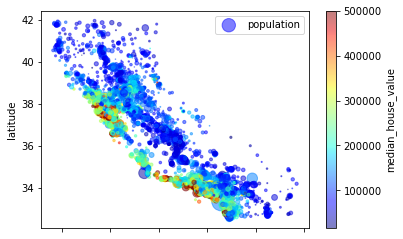

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

# El valor del parámetro alpha (0.5) hace que sea mucho más fácil
# visualizar los lugares donde hay una alta densidad de puntos de datos.

# Utilizaremos un mapa de colores predefinido (parámetro cmap) llamado jet, 
# que va del azul (precios bajos) al rojo (precios altos).

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)

plt.legend()

# El radio de cada círculo (parámetro s) representa la población del distrito,
# el color representa el precio (parámetro c).

---

Es hora de preparar los datos para nuestros algoritmos de Machine Learning.  

Pero primero volveremos a un training set limpio (copiando `strat_train_set` una vez más), y separaremos los predictores y las etiquetas.

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

La mayoría de los algoritmos de aprendizaje automático no pueden trabajar con características que faltan, así que vamos a crear algunas funciones para que se ocupen de ellas.

Scikit-Learn proporciona una clase muy útil para ocuparse de los valores perdidos: `Imputer`.

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Como la mediana sólo puede calcularse sobre atributos numéricos, necesitamos crear una copia de los datos sin el atributo de texto `ocean_proximity`:

In [26]:
housing_num = housing.drop("ocean_proximity", axis=1)

Ahora podemos ajustar la instancia del `Imputer` a los datos de entrenamiento utilizando el método `fit()`:

In [27]:
imputer.fit(housing_num)

# El Imputer calcula la mediana de cada atributo
# y almacena el resultado en su variable de instancia statistics_.

SimpleImputer(strategy='median')

Ahora podemos utilizar este `Imputer` "entrenado" para transformar el training set sustituyendo los valores perdidos por las medianas aprendidas:

In [28]:
X = imputer.transform(housing_num)

Anteriormente hemos omitido el atributo categórico `ocean_proximity` porque es un atributo de texto, por lo que no podemos calcular su mediana. La mayoría de los algoritmos de Machine Learning prefieren trabajar con números, así que convirtamos las etiquetas de texto a números.

Scikit-Learn provides a transformer for this task called LabelEncoder:

In [29]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 4, 1, ..., 0, 0, 1])

Scikit-Learn proporciona un codificador `OneHotEncoder` que utilizaremos para codificar las categorías como vectores `one_hot`. Tenga en cuenta que `fit_transform()` espera una matriz 2D, pero `housing_cat_encoded` es una matriz 1D, por lo que debemos reestructurarla utilizando `reshape()`:

In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

# Observe que la salida es una matriz sparse de SciPy, 
# lo que evita utilizar grandes cantidades de memoria para almacenar, en su mayoría, ceros.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Aunque Scikit-Learn proporciona muchos transformers útiles, tendremos que escribir el nuestros para tareas como operaciones de limpieza personalizadas o para combinar atributos específicos.  A continuación se presenta una pequeña clase que se ajusta a nuestros propósitos:

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Hay muchos pasos de transformación de datos que necesitan ser ejecutados en el orden correcto. Afortunadamente, Scikit-Learn proporciona la clase `Pipeline` para ayudar con tales secuencias de transformaciones.

A continuación, se presenta un pipeline que maneja tanto atributos numéricos como atributos categóricos:

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn_features.transformers import DataFrameSelector

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

Podemos ejecutar toda el pipeline de forma sencilla:

In [33]:
housing_prepared = full_pipeline.fit_transform(housing)

---

#### Ahora estamos listos para entrenar nuestros modelos de Machine Learning.

---

In [ ]:
# Utilizaremos los siguientes regresores de scikit-learn.
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Utilizaremos GridSearch para encontrar los mejores hiperparámetros.
from sklearn.model_selection import GridSearchCV

# La siguiente función recibe una lista de regresores y una lista de param_grids,
# y los utiliza para realizar un GridSearch para cada modelo. Después, imprime
# el nombre de cada regresor, sus mejores hiperparámetros y el mejor RMSE obtenido.
def finetune(regressors, grids):
    grid_index = 0
    for reg in regressors:
        reg.fit(housing_prepared, housing_labels)
        grid_search = GridSearchCV(reg, grids[grid_index], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(housing_prepared, housing_labels)
        print("Model:" + str(reg) + "\nBest hyperparameters:\n" + str(grid_search.best_params_) + 
              "\nRMSE: " +  str(np.sqrt(-grid_search.best_score_)))
        if(grid_index != len(grids)-1):
            print("\n")
        grid_index += 1

# Itareremos sobre la siguiente lista con nuestros regresores:
regressors = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor()
]

# Se genera una lista con los hiperparámetros a considerar para cada modelo.
grids = [
    {'fit_intercept': [True, False], 'n_jobs': [-1], 'copy_X': [True, False], 'positive': [True, False]},
    {'max_features': [2,4,6,8], 'ccp_alpha': [0.0,0.3,0.6,0.9],
     'criterion': ["poisson", "squared_error", "absolute_error", "friedman_mse"]},
    [{'n_estimators': [10,30,90], 'max_features': [2,4,6,8], 'ccp_alpha': [0.0,0.3,0.6,0.9]},
     {'bootstrap': [False], 'n_estimators': [10,30,90], 
      'max_features':[2,4,6,8], 'ccp_alpha': [0.0,0.3,0.6,0.9]}]
]

# Por último, llamamos a la función definida anteriormente.
finetune(regressors, grids)

Model:LinearRegression()
Best hyperparameters:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
RMSE: 69077.32049039399


Model:DecisionTreeRegressor()
Best hyperparameters:
{'ccp_alpha': 0.3, 'criterion': 'squared_error', 'max_features': 8}
RMSE: 70441.84413379607




Hemos finalizado con el entrenamiento de nuestros modelos. Basándonos en el RMSE obtenido por cada regresor, podemos determinar que el modelo que ha resultado más adecuado para este problema es el Random Forest, con un RMSE de 

El Random Forest es un algoritmo de Machine Learning flexible y fácil de usar que produce, incluso sin el ajuste de los hiperparámetros, un gran resultado la mayoría de las veces. Por su sencillez y diversidad, es uno de los algoritmos de Machine Learning más utilizados. 